# Phase 1

In [ ]:
# Install only once at the top
!pip install -q kagglehub[pandas-datasets]


In [ ]:
from pathlib import Path
import kagglehub

# Download dataset
BASE_ROOT = kagglehub.dataset_download("xdxd003/ff-c23")
BASE_ROOT = Path(BASE_ROOT)

# ✅ Actual FF++ root
DATA_ROOT = BASE_ROOT / "FaceForensics++_C23"

print("Corrected DATA_ROOT:", DATA_ROOT)
print("Folders:", [p.name for p in DATA_ROOT.iterdir() if p.is_dir()])


Using Colab cache for faster access to the 'ff-c23' dataset.
Corrected DATA_ROOT: /kaggle/input/ff-c23/FaceForensics++_C23
Folders: ['Face2Face', 'csv', 'Deepfakes', 'DeepFakeDetection', 'original', 'NeuralTextures', 'FaceShifter', 'FaceSwap']


In [ ]:
import pandas as pd

video_index = []

# REAL videos
for vid in (DATA_ROOT / "original").glob("*.mp4"):
    video_index.append({
        "video_path": str(vid),
        "label": "real",
        "manipulation": "original",
        "identity": vid.stem
    })

# FAKE videos
manipulation_folders = [
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures"
]

for manip in manipulation_folders:
    for vid in (DATA_ROOT / manip).glob("*.mp4"):
        identity = vid.stem.split("_")[0]   # FF++ identity convention
        video_index.append({
            "video_path": str(vid),
            "label": "fake",
            "manipulation": manip,
            "identity": identity
        })

videos_df = pd.DataFrame(video_index)
videos_df.head()


,video_path,label,manipulation,identity
0,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,123
1,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,738
2,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,479
3,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,660
4,/kaggle/input/ff-c23/FaceForensics++_C23/origi...,real,original,565


In [ ]:
print("Total videos:", len(videos_df))
print("\nLabel distribution:")
print(videos_df["label"].value_counts())

print("\nManipulation distribution:")
print(videos_df["manipulation"].value_counts())

print("\nUnique identities:", videos_df["identity"].nunique())


Total videos: 7000

Label distribution:
label
fake    6000
real    1000
Name: count, dtype: int64

Manipulation distribution:
manipulation
original             1000
DeepFakeDetection    1000
Deepfakes            1000
Face2Face            1000
FaceShifter          1000
FaceSwap             1000
NeuralTextures       1000
Name: count, dtype: int64

Unique identities: 1028


In [ ]:
import random

random.seed(42)

identities = videos_df["identity"].unique().tolist()
random.shuffle(identities)

n = len(identities)
train_ids = identities[:int(0.6 * n)]
val_ids   = identities[int(0.6 * n):int(0.8 * n)]
test_ids  = identities[int(0.8 * n):]

train_df = videos_df[videos_df["identity"].isin(train_ids)]
val_df   = videos_df[videos_df["identity"].isin(val_ids)]
test_df  = videos_df[videos_df["identity"].isin(test_ids)]

# Safety checks
assert set(train_ids).isdisjoint(val_ids)
assert set(train_ids).isdisjoint(test_ids)
assert set(val_ids).isdisjoint(test_ids)

print("✅ Identity-disjoint splits verified")
print("Train videos:", len(train_df))
print("Val videos  :", len(val_df))
print("Test videos :", len(test_df))


✅ Identity-disjoint splits verified
Train videos: 4038
Val videos  : 1418
Test videos : 1544


In [ ]:
from collections import defaultdict

def build_task_pools(df):
    tasks = defaultdict(list)
    for _, row in df.iterrows():
        task_name = f"FFPP_{row['manipulation']}"
        tasks[task_name].append({
            "video_path": row["video_path"],
            "label": row["label"],
            "identity": row["identity"]
        })
    return tasks

meta_train_tasks = build_task_pools(train_df)
meta_val_tasks   = build_task_pools(val_df)
meta_test_tasks  = build_task_pools(test_df)

print("Meta-train tasks:", meta_train_tasks.keys())


Meta-train tasks: dict_keys(['FFPP_original', 'FFPP_DeepFakeDetection', 'FFPP_Deepfakes', 'FFPP_Face2Face', 'FFPP_FaceShifter', 'FFPP_FaceSwap', 'FFPP_NeuralTextures'])


In [ ]:
import json

PHASE1_OUT = Path("/content/phase1_tasks/ffpp")
PHASE1_OUT.mkdir(parents=True, exist_ok=True)

with open(PHASE1_OUT / "meta_train_tasks.json", "w") as f:
    json.dump(meta_train_tasks, f, indent=2)

with open(PHASE1_OUT / "meta_val_tasks.json", "w") as f:
    json.dump(meta_val_tasks, f, indent=2)

with open(PHASE1_OUT / "meta_test_tasks.json", "w") as f:
    json.dump(meta_test_tasks, f, indent=2)

print("✅ Phase 1 task files saved at:", PHASE1_OUT)


✅ Phase 1 task files saved at: /content/phase1_tasks/ffpp


# Phase 2

In [ ]:
# ===== Colab setup =====
!pip install -q numpy==1.23.5
!pip install -q mtcnn facenet-pytorch kagglehub opencv-python-headless==4.9.0.80


  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import numpy as np
import torch
import cv2
from mtcnn import MTCNN

print("NumPy:", np.__version__)
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
print("OpenCV:", cv2.__version__)

detector = MTCNN()
print("✅ MTCNN initialized successfully")


NumPy: 1.26.4
Torch: 2.2.2+cu121
CUDA: True
OpenCV: 4.9.0
✅ MTCNN initialized successfully


In [ ]:
import cv2
import numpy as np

def extract_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total <= 0:
        cap.release()
        return []

    idxs = np.linspace(0, total - 1, num_frames, dtype=int)

    frames = []
    for i in idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frames.append(frame)

    cap.release()
    return frames


In [ ]:
from mtcnn import MTCNN

detector = MTCNN()


In [ ]:
def extract_faces(frames):
    faces = []

    for frame in frames:
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(rgb)

        if not results:
            continue

        x, y, w, h = results[0]["box"]
        x, y = max(0, x), max(0, y)
        face = rgb[y:y+h, x:x+w]

        if face.size == 0:
            continue

        face = cv2.resize(face, (224, 224))
        faces.append(face)

    return faces


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as T

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights="IMAGENET1K_V1")
model.fc = torch.nn.Identity()
model = model.to(device).eval()

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


In [ ]:
def embed_faces(faces):
    embeddings = []
    with torch.no_grad():
        for face in faces:
            x = transform(face).unsqueeze(0).to(device)
            emb = model(x).cpu().numpy()[0]
            embeddings.append(emb)
    return embeddings


In [ ]:
def aggregate_embeddings(embeddings):
    return np.mean(np.stack(embeddings), axis=0)


In [ ]:
import json
from pathlib import Path

PHASE1_PATH = Path("/content/phase1_tasks/ffpp/meta_train_tasks.json")
PHASE2_OUT  = Path("/content/data/processed/embeddings/ffpp")

PHASE2_OUT.mkdir(parents=True, exist_ok=True)

with open(PHASE1_PATH) as f:
    tasks = json.load(f)

for task_name, videos in tasks.items():
    task_dir = PHASE2_OUT / task_name
    task_dir.mkdir(parents=True, exist_ok=True)

    for v in videos:
        video_path = v["video_path"]
        video_id = Path(video_path).stem

        frames = extract_frames(video_path)
        faces = extract_faces(frames)

        if len(faces) < 3:
            continue

        embs = embed_faces(faces)
        video_emb = aggregate_embeddings(embs)

        np.save(
            task_dir / f"{video_id}.npy",
            {
                "embedding": video_emb,
                "label": v["label"],
                "identity": v["identity"]
            }
        )


KeyboardInterrupt: 

In [ ]:
import time

MAX_VIDEOS_PER_TASK = 5  # remove later for full run

for task_name, videos in tasks.items():
    task_dir = PHASE2_OUT / task_name
    task_dir.mkdir(parents=True, exist_ok=True)

    for v in videos[:MAX_VIDEOS_PER_TASK]:
        video_path = v["video_path"]
        video_id = Path(video_path).stem

        frames = extract_frames(video_path, num_frames=5)
        if len(frames) == 0:
            continue

        t0 = time.time()
        faces = extract_faces(frames)

        if len(faces) < 3:
            continue

        embs = embed_faces(faces)
        video_emb = aggregate_embeddings(embs)

        np.save(
            task_dir / f"{video_id}.npy",
            {
                "embedding": video_emb,
                "label": v["label"],
                "identity": v["identity"]
            }
        )

        print(
            f"[{task_name}] {video_id} | "
            f"faces={len(faces)} | "
            f"time={time.time() - t0:.2f}s"
        )


[FFPP_original] 738 | faces=5 | time=4.22s
[FFPP_original] 565 | faces=5 | time=1.39s
[FFPP_original] 033 | faces=5 | time=1.65s
[FFPP_original] 581 | faces=5 | time=8.24s
[FFPP_original] 408 | faces=5 | time=2.06s
[FFPP_DeepFakeDetection] 26_12__walking_down_street_outside_angry__OVOQACG8 | faces=5 | time=9.84s
[FFPP_DeepFakeDetection] 15_06__exit_phone_room__E98QYYXO | faces=5 | time=8.86s
[FFPP_DeepFakeDetection] 26_25__outside_talking_still_laughing__7ZRKCFMS | faces=5 | time=12.79s
[FFPP_DeepFakeDetection] 15_03__podium_speech_happy__Y11NT1YX | faces=5 | time=9.29s
[FFPP_DeepFakeDetection] 26_01__secret_conversation__BTVMWLG6 | faces=5 | time=9.21s
[FFPP_Deepfakes] 315_322 | faces=5 | time=1.65s
[FFPP_Deepfakes] 645_688 | faces=5 | time=9.34s
[FFPP_Deepfakes] 700_813 | faces=5 | time=3.86s
[FFPP_Deepfakes] 313_283 | faces=5 | time=1.81s
[FFPP_Deepfakes] 336_338 | faces=5 | time=2.41s
[FFPP_Face2Face] 315_322 | faces=5 | time=1.62s
[FFPP_Face2Face] 645_688 | faces=5 | time=12.11s
[

In [ ]:
# Pick any one video from meta_train_tasks
example_task = list(tasks.keys())[0]
example_video = tasks[example_task][0]["video_path"]

print("Task:", example_task)
print("Video:", example_video)


Task: FFPP_original
Video: /kaggle/input/ff-c23/FaceForensics++_C23/original/738.mp4


In [ ]:
import cv2
import numpy as np

def extract_single_frame(video_path, frame_ratio=0.5):
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idx = int(total * frame_ratio)

    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    ret, frame = cap.read()
    cap.release()

    return frame if ret else None

frame = extract_single_frame(example_video)


In [ ]:
from mtcnn import MTCNN

detector = MTCNN()

def detect_face(frame):
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(rgb)

    if not results:
        return None

    x, y, w, h = results[0]["box"]
    x, y = max(0, x), max(0, y)

    face = rgb[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return face


In [ ]:
face = detect_face(frame)


In [ ]:
import matplotlib.pyplot as plt

def show_comparison(original, face):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original Video Frame")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    if face is not None:
        plt.imshow(face)
        plt.title("Face Crop (MTCNN)")
    else:
        plt.text(0.5, 0.5, "No Face Detected", ha="center", va="center")
    plt.axis("off")

    plt.show()


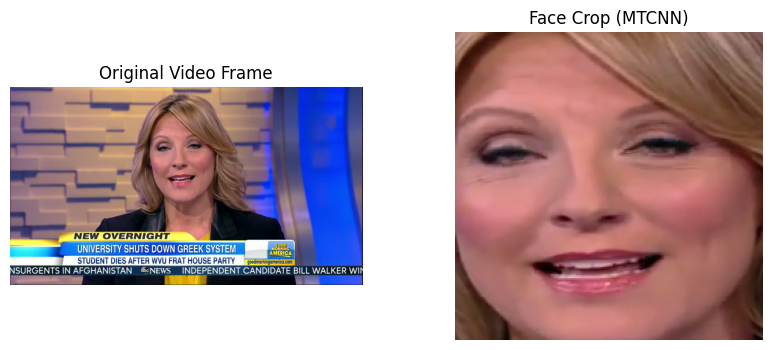

In [ ]:
show_comparison(frame, face)


In [ ]:
import torchvision.transforms as T

normalize = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def show_model_input(face):
    tensor = normalize(face)
    img = tensor.permute(1, 2, 0).numpy()

    # Rescale for visualization
    img = (img - img.min()) / (img.max() - img.min())

    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.title("Normalized Input to CNN")
    plt.axis("off")
    plt.show()


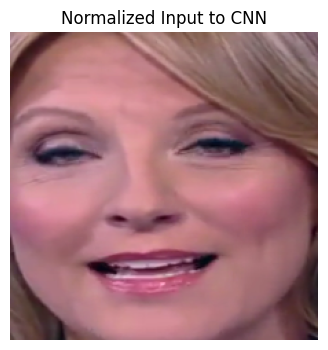

In [ ]:
if face is not None:
    show_model_input(face)
